In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

#import excursion
import sys
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion')
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/testcases/')

import testcases.oned_fast as scandetails
import excursion.optimize 


import numpy as np
import excursion.utils as utils


sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/utils/')
from utils import point_entropy, point_entropy_gpytorch, mesh2points, points2mesh, values2mesh

import datetime

sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/plotting/')
import plotting.onedim as plots

np.warnings.filterwarnings('ignore')

import math

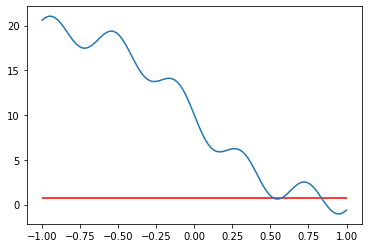

In [3]:
for func in scandetails.truth_functions:
    plt.plot(scandetails.plotX.ravel(),func(scandetails.plotX).ravel(), label=str(func))
    
for thr in scandetails.thresholds:
    plt.hlines(thr, np.min(scandetails.plotX),np.max(scandetails.plotX), colors = 'red', label=str(thr))


In [4]:
import torch
y_true = func(scandetails.plotX).ravel()
X_grid = torch.tensor(scandetails.plotX.ravel())

### 1) GP model specification
prior:
 - RBF kernel 
 - constant mean

In [5]:
import gpytorch

In [6]:
# simplest form of GP model RBF with constant mean prior, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### 2) Likelihood / observational model

excursion: $\epsilon = 0$

In [7]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor([0]))

### 3) Model

initialization: $x_0$ (2 points)

In [8]:
np.random.seed(1)
X = torch.from_numpy(\
          np.random.uniform(scandetails.plot_rangedef[:,0],scandetails.plot_rangedef[:,1], size = (2,)) )

y_list = torch.from_numpy(\
          np.array([scandetails.truth_functions[0](np.asarray([x]))[0] for x in X]) )

print('X_0 = ', X)
print('f(X_0) = ', y_list)

X_0 =  tensor([-0.1660,  0.4406], dtype=torch.float64)
f(X_0) =  tensor([14.1128,  2.4481], dtype=torch.float64)


### 4) Acquisition of new points maximizing info gain: testing

In [9]:
#call info gain
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/optimize/')
import optimize.core as optimizecore
#info_gain_candidate = optimizecore.info_gain_gpytorch(xcandidate, gps, thresholds, X_grid)
#print('info gain of xcandidate = '+str(xcandidate[0])+' given training set :', info_gain_candidate)

In [10]:
sys.path.insert(0, '/home/irina/Documents/PROJECTS/excursion/excursion/optimize')
import optimize as optimize
import imp
imp.reload(optimize)
imp.reload(optimizecore)
#newx, acqvals = optimize.gridsearch_gpytorch(gps, X, scandetails)

<module 'optimize.core' from '/home/irina/Documents/PROJECTS/excursion/excursion/optimize/core.py'>

### 5) Contour approximation

In [11]:
def plot_and_save(workdir, index, *args):
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(9.5, 3.5)
    gp = args[0]
    plots.plot_gpytorch(axarr,gp, likelihood, X, y_list, scandetails)
    plt.tight_layout()
    plt.savefig(os.path.join(workdir,'update_{}.png'.format(str(index).zfill(3))), bbox_inches = 'tight')
    plt.show()

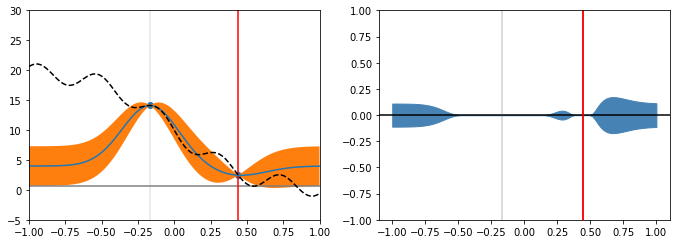

info_gain
taking new x. best non-existent index 0 [-0.17171717]
Iteration 0. Evaluted function 2 to values: [[14.10958117]] 



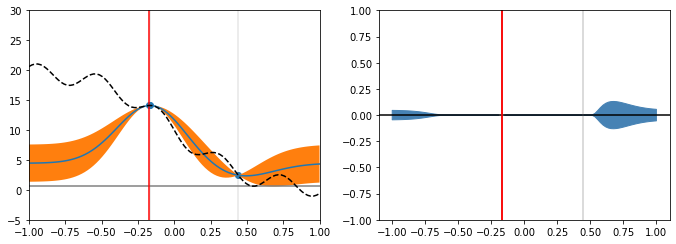

info_gain
taking new x. best non-existent index 0 [-1.]
Iteration 1. Evaluted function 3 to values: [[20.61570756]] 



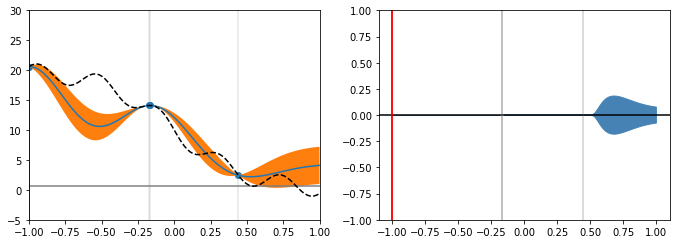

info_gain
taking new x. best non-existent index 0 [-0.15151515]
Iteration 2. Evaluted function 4 to values: [[14.08622822]] 



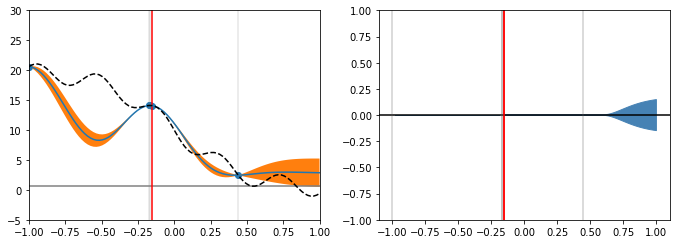

info_gain
taking new x. best non-existent index 0 [-0.09090909]
Iteration 3. Evaluted function 5 to values: [[13.26633669]] 



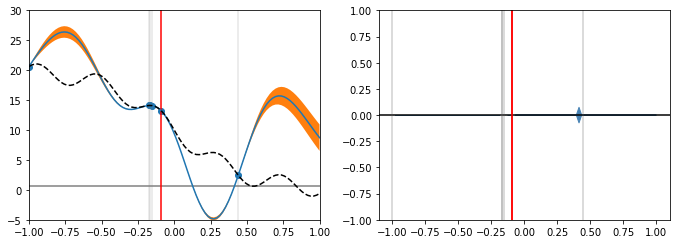

info_gain
taking new x. best non-existent index 0 [1.]
Iteration 4. Evaluted function 6 to values: [[-0.61570756]] 



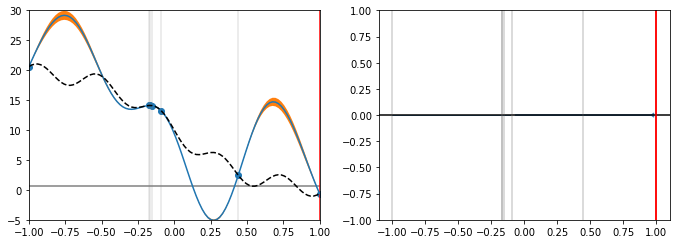

info_gain
taking new x. best non-existent index 0 [0.75757576]
Iteration 5. Evaluted function 7 to values: [[2.32104969]] 



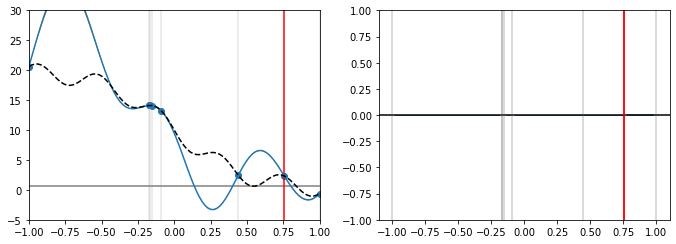

info_gain
taking new x. best non-existent index 0 [-0.75757576]
Iteration 6. Evaluted function 8 to values: [[17.67895031]] 



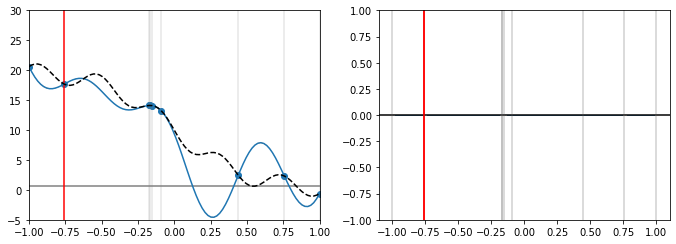

info_gain
[-1.] is good but already there
[0.75757576] is good but already there
taking new x. best non-existent index 2 [-0.05050505]
Iteration 7. Evaluted function 9 to values: [[12.03742297]] 



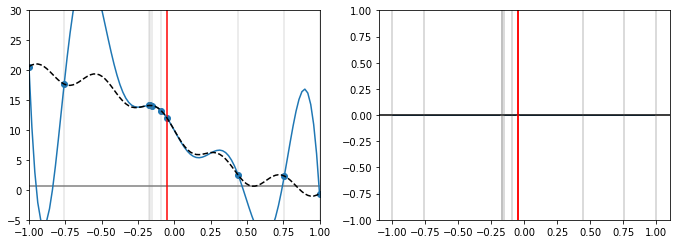

info_gain
[-1.] is good but already there
taking new x. best non-existent index 1 [-0.27272727]
Iteration 8. Evaluted function 10 to values: [[13.75153087]] 



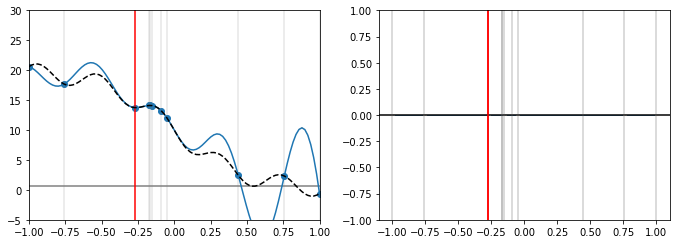

info_gain
[-1.] is good but already there
taking new x. best non-existent index 1 [-0.35353535]
Iteration 9. Evaluted function 11 to values: [[14.84249108]] 



In [12]:
import imp
imp.reload(plots)
imp.reload(utils)

import datetime
workdir = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S-2dmulti')
os.mkdir(workdir)

N_UPDATES = 10

for index in range(N_UPDATES):
    
    model = ExactGPModel(X, y_list, likelihood)
    gps = [model]
    
    #training the model with new points and optimize hyperparams
    optimize.train_hyperparameters(gps[0], X, y_list, likelihood, optimizer='Adam')

    #now plot and obtain next point that maximizes info gain
    plot_and_save(workdir, index, gps[0], likelihood, X, y_list, scandetails)

    newx, acqvals = optimize.gridsearch_gpytorch(gps, X, scandetails)
    
    newys_list = [scandetails.truth_functions[0](np.asarray([newx]))]
    
    for i,newys in enumerate(newys_list):
        i_eff = i + len(y_list)
        print('Iteration {}. Evaluted function {} to values: {} \n'.format(index, i_eff,newys))
        y_list = torch.cat( (y_list, torch.tensor(newys[0]) ), -1 )
        
    #update training points
    X = torch.from_numpy( np.concatenate( [X, np.array([newx[0]])] ) )